## Imports

In [427]:
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git
%cd NASA-Material-Classifier
!pip install xgboost
import numpy as np
np.random.seed(1000)
import pandas as pd
import torch.nn.functional as F
from tensorflow.keras.losses import mean_absolute_error
import tensorflow as tf
tf.random.set_seed(1000)
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import scipy.io
from tensorflow.keras.callbacks import ReduceLROnPlateau
import torch.nn as nn
from sklearn.model_selection import train_test_split
import uuid
import torch
from keras.layers import Bidirectional, LSTM, Dense
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 162 (delta 1), reused 10 (delta 1), pack-reused 150
Receiving objects: 100% (162/162), 227.45 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (65/65), done.
/content/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier/NASA-Material-Classifier


# Preprocessing Moon Rock

In [428]:
file_paths = dict()
file_paths[0] = [
    "data/moon_rock/simulated/S11_parameter_data_for_zero_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_zero_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_zero_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_zero_orientation.txt"]
file_paths[1] = [
    "data/moon_rock/simulated/S11_parameter_data_for_CW90_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_CW90_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_CW90_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_CW90_orientation.txt"]
file_paths[2] = [
    "data/moon_rock/simulated/S11_parameter_data_for_CCW90_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_CCW90_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_CCW90_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_CCW90_orientation.txt"]
file_paths[3] = [
    "data/moon_rock/simulated/S11_parameter_data_for_tilt_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_tilt_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_tilt_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_tilt_orientation.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [429]:
file_paths = dict()
file_paths[0] = ["data/moon_rock/actual/mea_rot_0.txt"]
file_paths[1] = ["data/moon_rock/actual/mea_rot_cw90.txt"]
file_paths[2] = ["data/moon_rock/actual/mea_rot_ccw90.txt"]
file_paths[3] = ["data/moon_rock/actual/mea_rot_0_tilt.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    dictionary = {
    0: "S11",
    1: "S21",
    2: "S12",
    3: "S22"
    }
    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = dictionary[index]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for group in range(len(all_combined_data)):
    for i in range(0, len(all_combined_data[group]), group_size):
        combined_dataframe = pd.concat(all_combined_data[group][i:i+group_size], axis=1)
        combined_dataframe.reset_index(drop=True, inplace=True)
        array.append(combined_dataframe)
testing_dataframe = pd.concat(array, axis=0)
testing_dataframe.reset_index(drop=True, inplace=True)
testing_dataframe = testing_dataframe.loc[:, ~testing_dataframe.columns.duplicated()]

In [430]:
print(training_dataframe.columns)
print(testing_dataframe.columns)

Index(['Frequency', 'data/moon_rock/simulated/S11_Real',
       'data/moon_rock/simulated/S11_Imaginary', 'Orientation', 'ID', 'er1',
       ' er11', 'data/moon_rock/simulated/S12_Real',
       'data/moon_rock/simulated/S12_Imaginary',
       'data/moon_rock/simulated/S21_Real',
       'data/moon_rock/simulated/S21_Imaginary',
       'data/moon_rock/simulated/S22_Real',
       'data/moon_rock/simulated/S22_Imaginary'],
      dtype='object')
Index(['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID', ' er1',
       ' er11', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary',
       'S22_Real', 'S22_Imaginary'],
      dtype='object')


In [431]:
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [432]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [433]:
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [434]:
training_dataframe = training_dataframe.iloc[:,1:]
testing_dataframe = testing_dataframe.iloc[:,1:]

In [435]:
testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1

In [436]:
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,0.022609,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,1.0007,0,0.022609,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,1.0014,0,0.022609,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,1.0021,0,0.022609,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,1.0028,0,0.022609,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [437]:
testing_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,0.05,0.1,-0.019713,-0.006039,0.999223,-0.020864,0.998418,-0.021599,0.021095,-0.006780
1,1.0007,0,0.05,0.1,-0.019483,-0.006385,0.998718,-0.020889,0.998630,-0.021391,0.020911,-0.007270
2,1.0014,0,0.05,0.1,-0.019138,-0.006591,0.998271,-0.020941,0.998445,-0.021038,0.020691,-0.007730
3,1.0021,0,0.05,0.1,-0.018813,-0.006997,0.998203,-0.020768,0.998248,-0.020766,0.020422,-0.008105
4,1.0028,0,0.05,0.1,-0.018616,-0.007612,0.998520,-0.020519,0.998265,-0.020615,0.020164,-0.008383


In [438]:
training_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000
mean,1.350000,1.500000,0.051183,0.048120,-0.001584,-0.002185,-0.047022,-0.054192,-0.047022,-0.054192,0.000979,-0.001394
std,0.202275,1.118035,0.022764,0.028907,0.015331,0.016359,0.717936,0.684740,0.717936,0.684740,0.016112,0.015731
min,1.000000,0.000000,0.010952,0.000463,-0.035654,-0.041414,-0.995684,-0.994878,-0.995684,-0.994878,-0.039840,-0.041402
25%,1.175000,0.750000,0.030552,0.023333,-0.012621,-0.013896,-0.764701,-0.733799,-0.764701,-0.733799,-0.010682,-0.012373
50%,1.350000,1.500000,0.053121,0.045073,-0.002871,-0.001957,-0.111570,-0.084830,-0.111570,-0.084830,0.001433,-0.000090
75%,1.525000,2.250000,0.070425,0.077511,0.008562,0.009605,0.685784,0.613695,0.685784,0.613695,0.012647,0.010078
max,1.700000,3.000000,0.087647,0.099613,0.041451,0.040683,0.995090,0.995193,0.995090,0.995193,0.040707,0.035653


In [439]:
testing_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,4004.0000,4004.000000,4.004000e+03,4.004000e+03,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,1.3500,1.500000,5.000000e-02,1.000000e-01,0.000577,0.000549,0.999238,-0.015901,0.999127,-0.016045,0.000196,0.000537
std,0.2023,1.118174,6.939761e-18,1.387952e-17,0.011171,0.011518,0.000563,0.002759,0.000539,0.002727,0.011191,0.011311
min,1.0000,0.000000,5.000000e-02,1.000000e-01,-0.020254,-0.019533,0.997404,-0.022488,0.997087,-0.022932,-0.016647,-0.019633
25%,1.1750,0.750000,5.000000e-02,1.000000e-01,-0.009929,-0.010517,0.998914,-0.017570,0.998798,-0.017717,-0.010537,-0.010187
50%,1.3500,1.500000,5.000000e-02,1.000000e-01,0.000705,0.001933,0.999316,-0.016833,0.999181,-0.016949,-0.000033,0.001886
75%,1.5250,2.250000,5.000000e-02,1.000000e-01,0.010853,0.011191,0.999648,-0.015271,0.999511,-0.015336,0.010635,0.010881
max,1.7000,3.000000,5.000000e-02,1.000000e-01,0.019258,0.017582,1.000619,-0.010323,1.000495,-0.010558,0.021095,0.017354


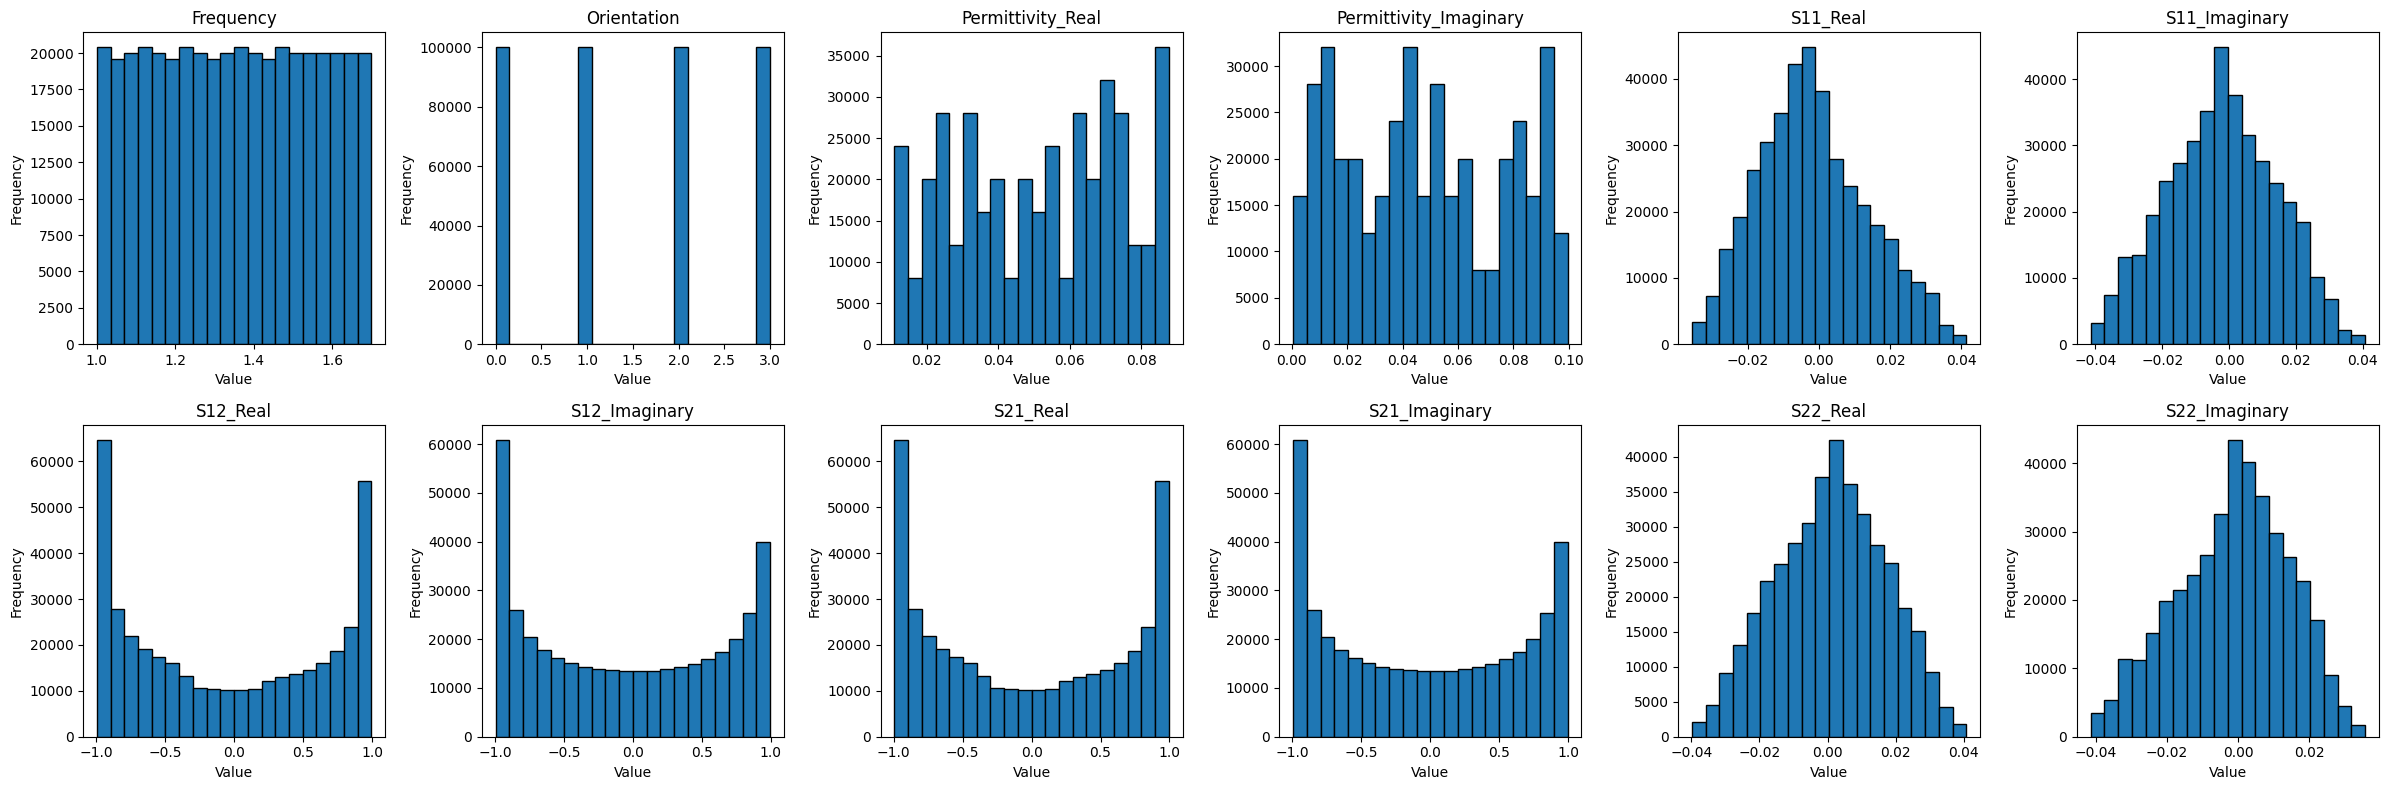

In [440]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

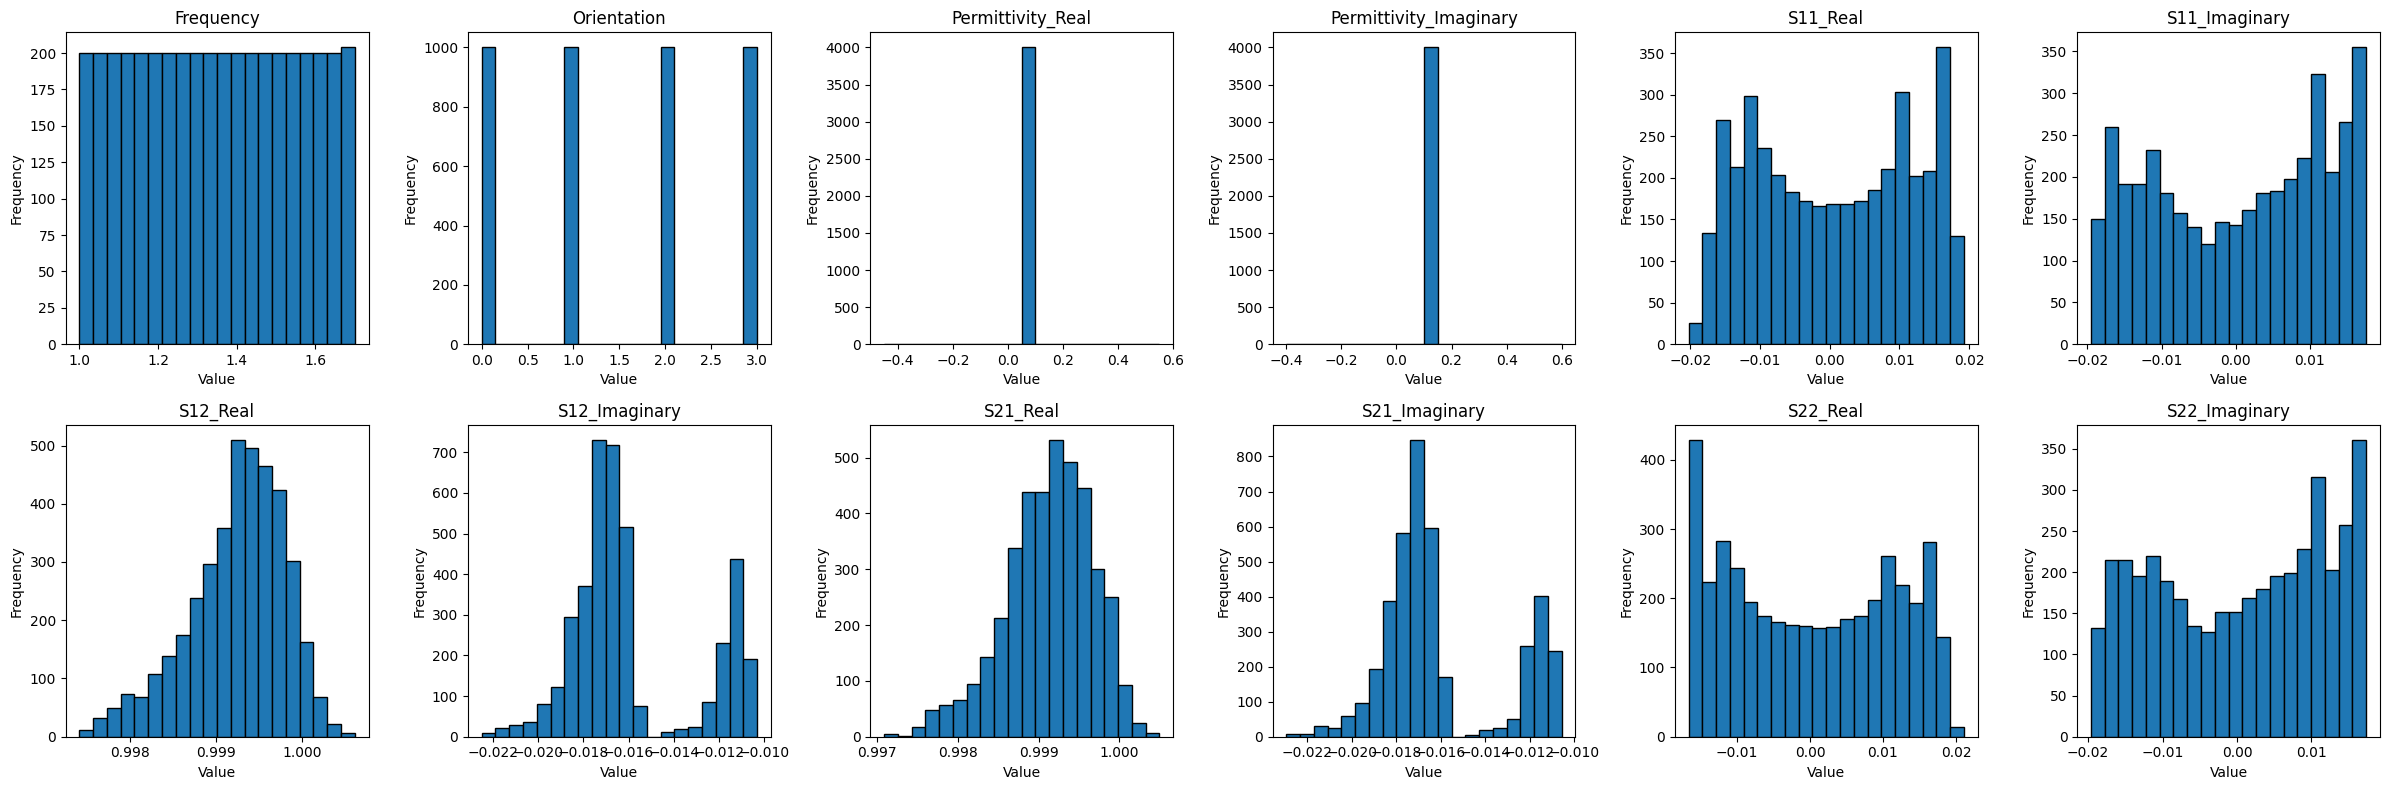

In [441]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [442]:
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

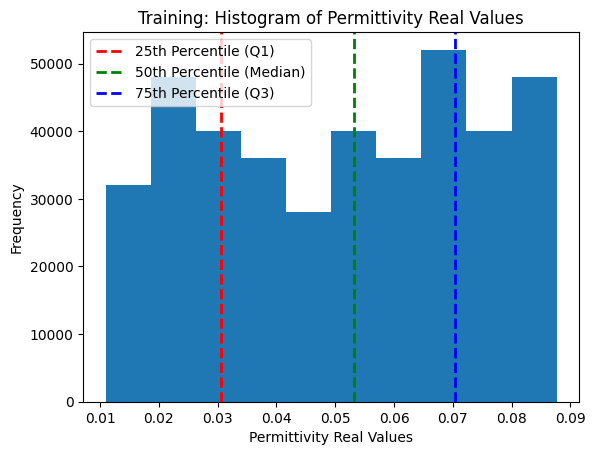

In [443]:
q25 = np.percentile(training_dataframe["Permittivity_Real"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Real"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Real"], 75)
plt.hist(training_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Real Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

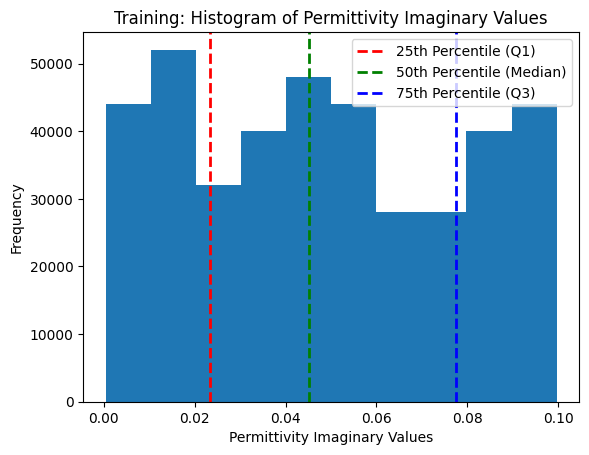

In [444]:
q25 = np.percentile(training_dataframe["Permittivity_Imaginary"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Imaginary"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Imaginary"], 75)
plt.hist(training_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Imaginary Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

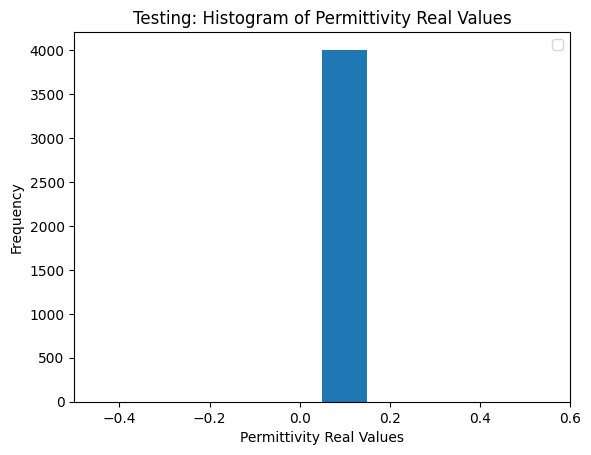

In [445]:
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

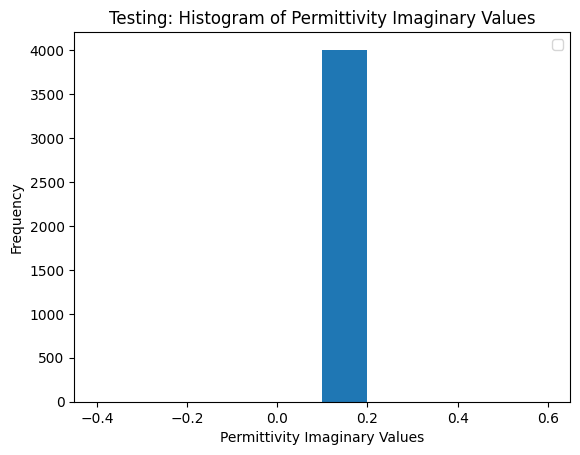

In [446]:
plt.hist(testing_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Imaginary Values")
plt.legend()
plt.show()

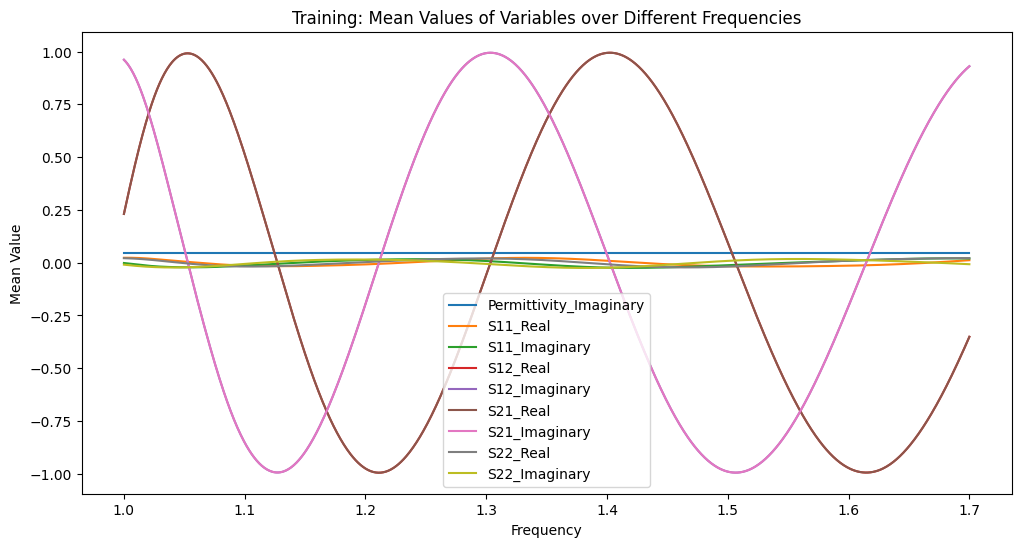

In [447]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

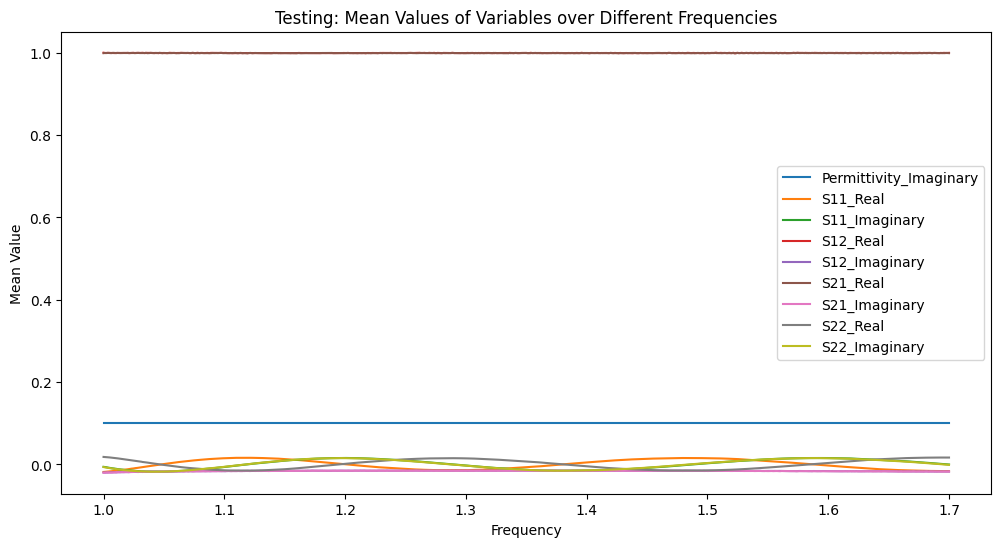

In [448]:
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Testing: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

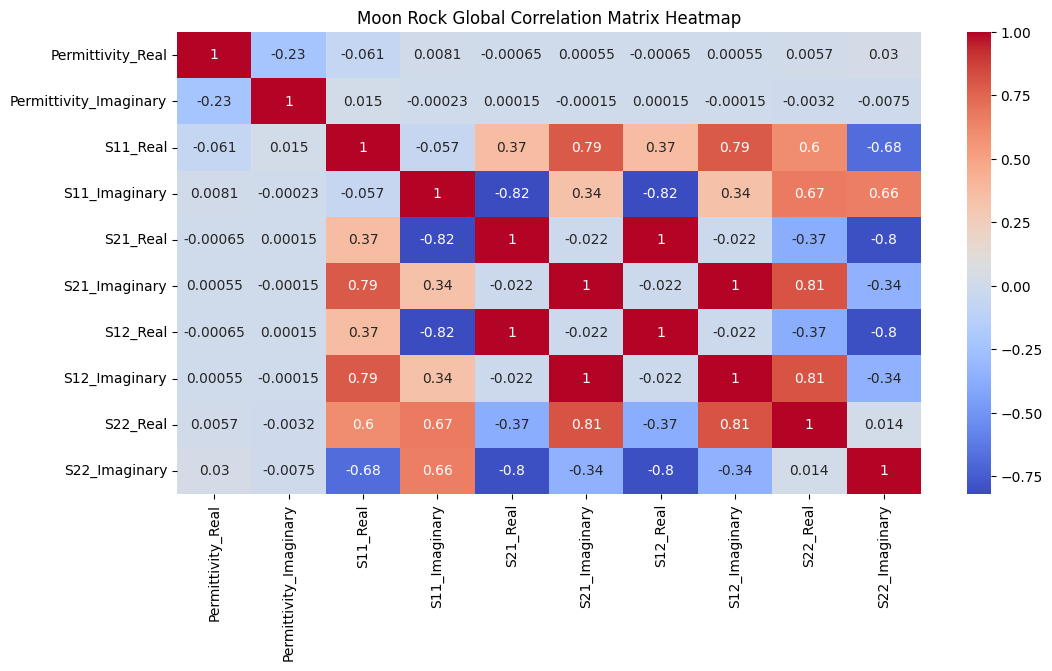

In [449]:
plt.figure(figsize=(12, 6))
sns.heatmap(training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real','S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real','S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Moon Rock Global Correlation Matrix Heatmap')
plt.show()

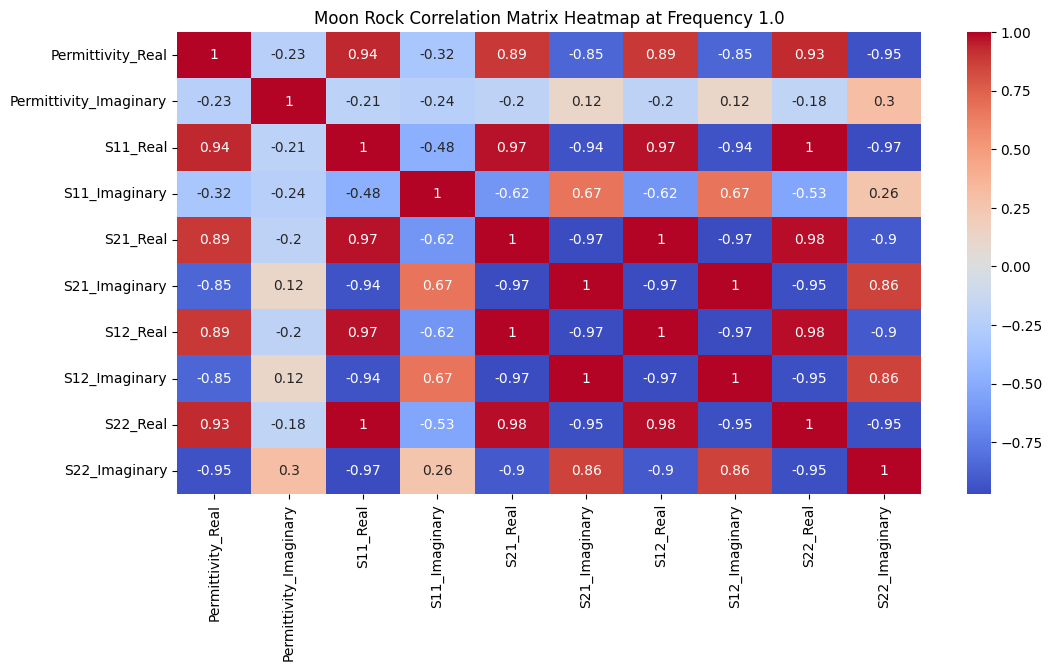

<Figure size 1200x600 with 0 Axes>

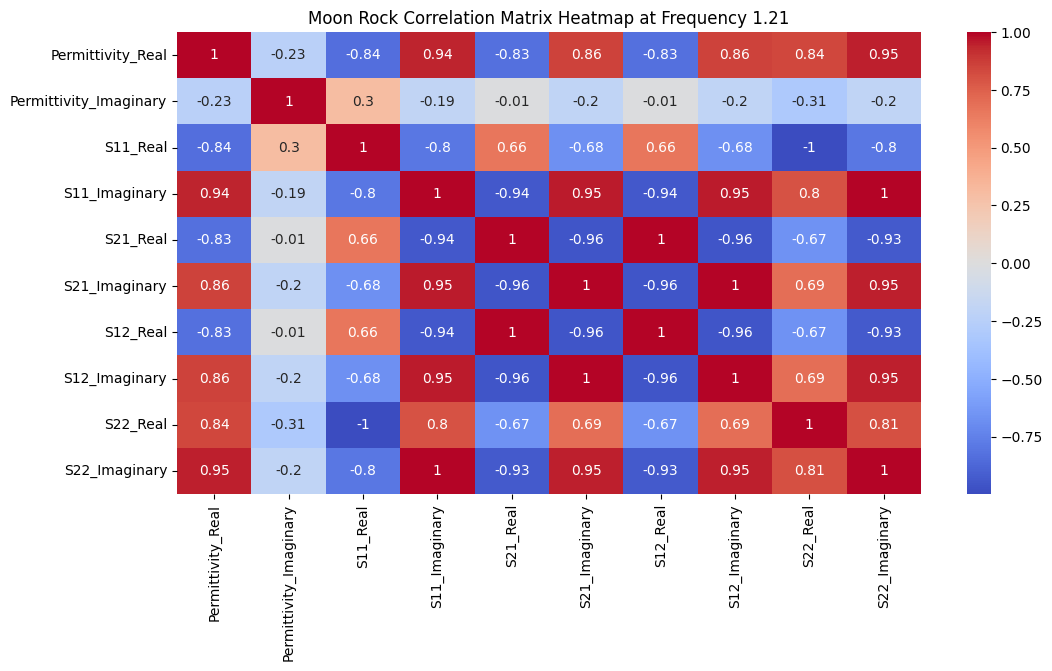

<Figure size 1200x600 with 0 Axes>

In [450]:
unique_frequencies = np.unique(training_dataframe["Frequency"])
count = 0
for i in range(0, len(unique_frequencies), 300):
    if count < 2:
        plt.figure(figsize=(12, 6))
        sample = training_dataframe[training_dataframe["Frequency"] == unique_frequencies[i]]
        sns.heatmap(sample[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real', 'S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
        plt.title(f'Moon Rock Correlation Matrix Heatmap at Frequency {np.round(unique_frequencies[i],3)}')
        plt.figure(figsize=(12, 6))
        count += 1
    else:
        break


In [451]:
no_id = [
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [452]:
moon_non_old_testing = testing_dataframe.copy()

In [453]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
bc = QuantileTransformer(random_state=42)
bc.fit(training_dataframe[no_id])
training_dataframe[training_dataframe[no_id].columns] = bc.transform(training_dataframe[no_id])
testing_dataframe[testing_dataframe[no_id].columns]  = bc.transform(testing_dataframe[no_id])

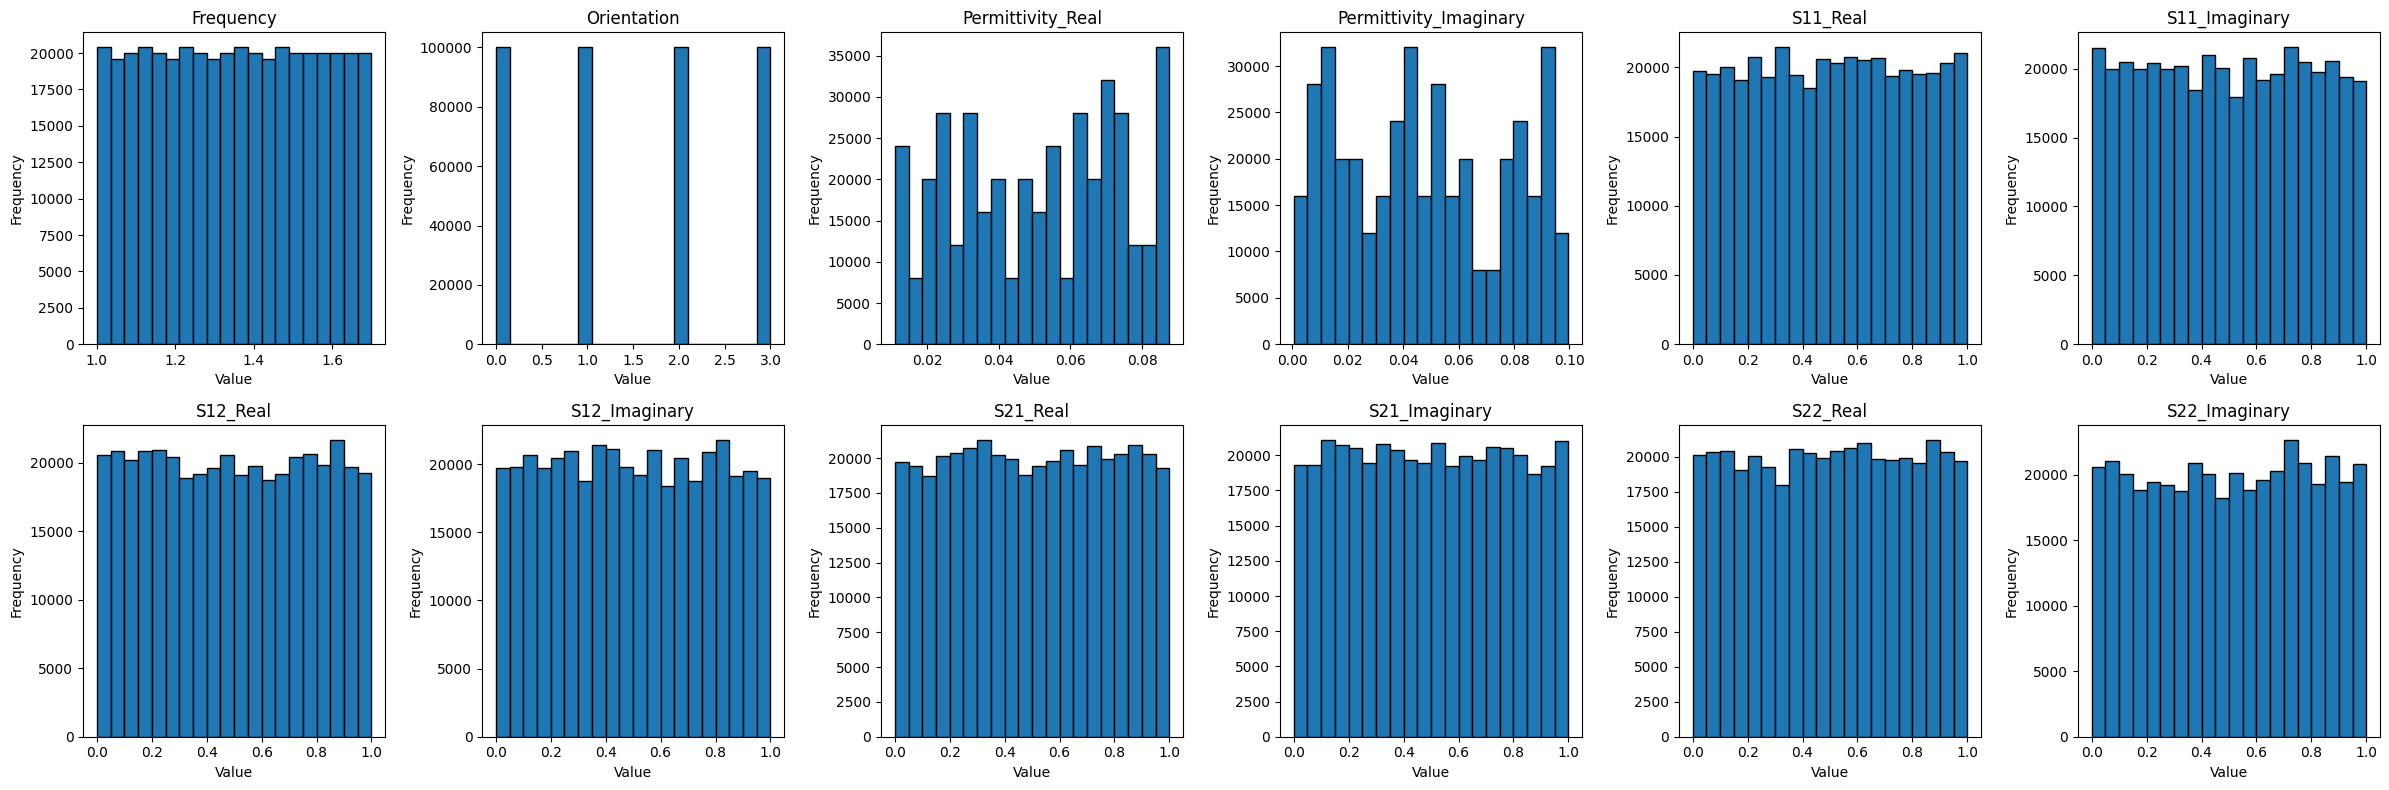

In [454]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

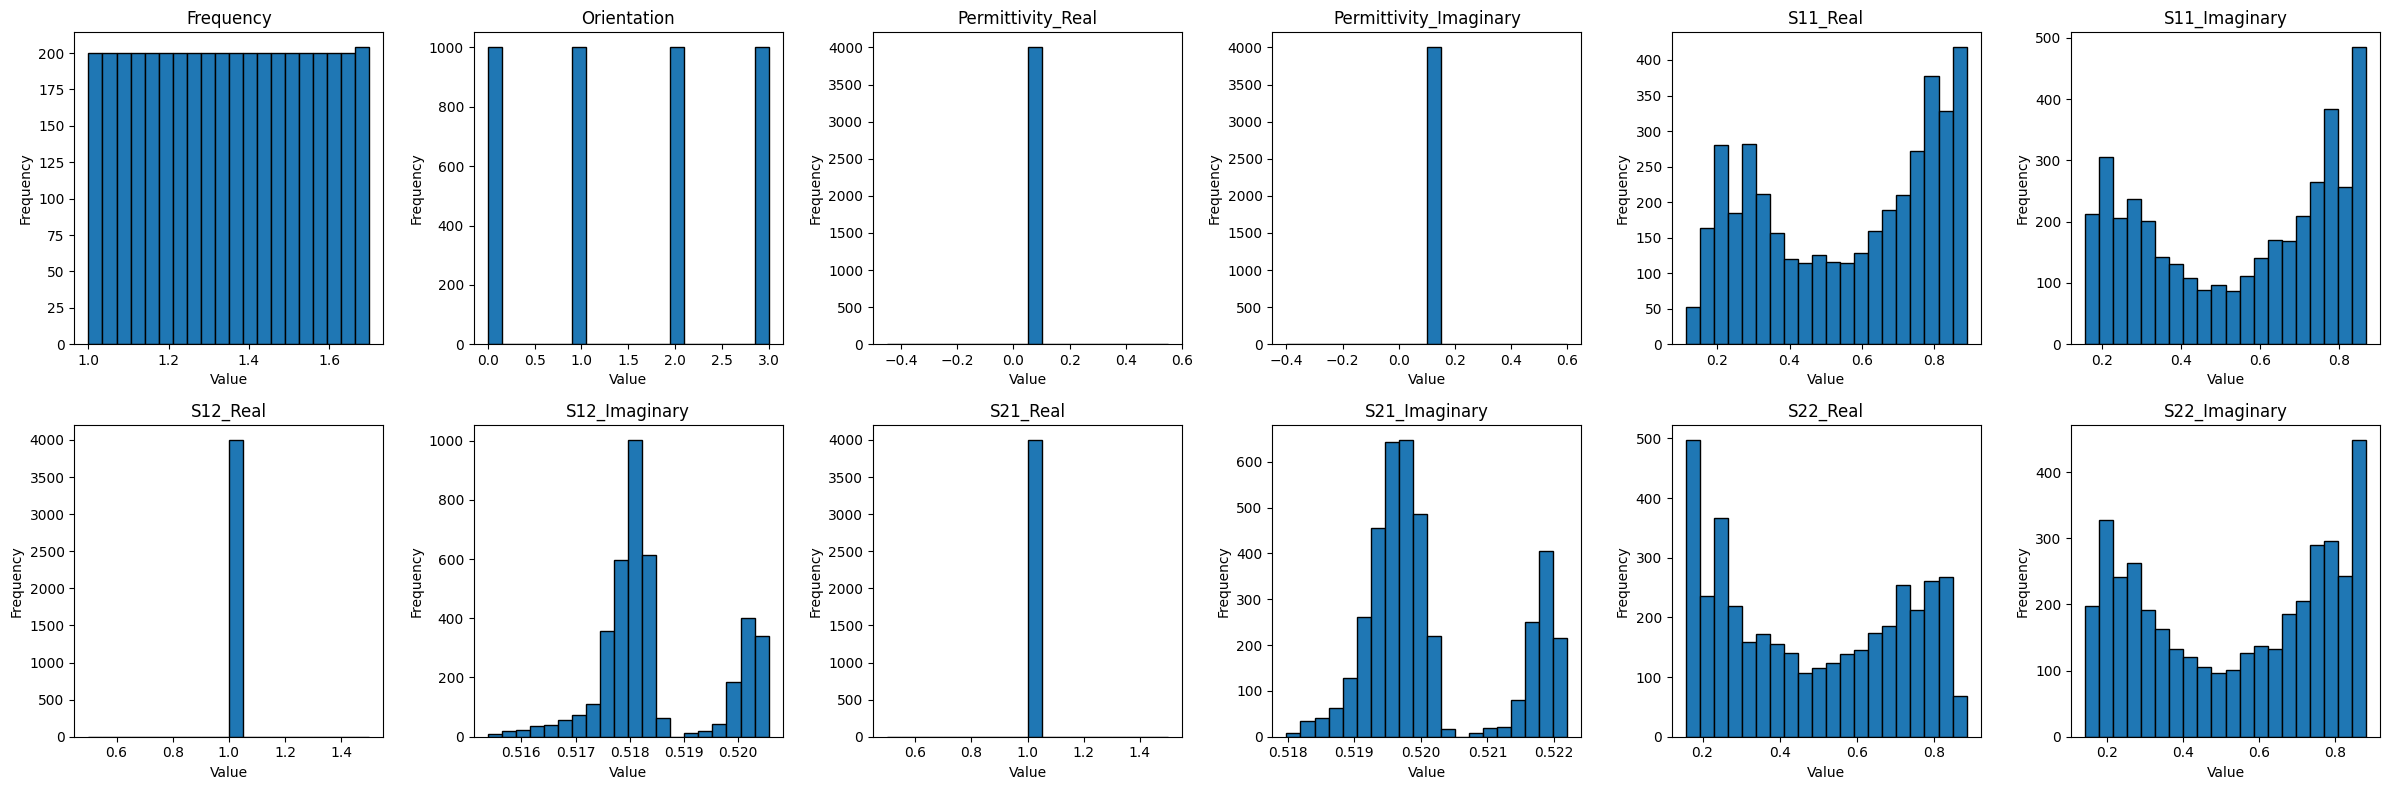

In [455]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [456]:
moon_old_testing = testing_dataframe.copy()

# Feedforward Neural Network Moon Rock

In [457]:
models = []

## Learning from Individual Observations without Considering Measurement Order (Randomized)

In [458]:
LR = 0.0001
L2 = 0.0001
WD = 0.000001

In [459]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID","Orientation","Frequency"]:
        columns.append(column)
columns

['S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [460]:
X_train = training_dataframe[columns].values
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
grouped_indices = {}
for idx in selected_indices:
    row = training_dataframe.iloc[idx]
    orientation = row['Orientation']
    frequency = row['Frequency']
    key = (orientation, frequency)
    if key not in grouped_indices:
        grouped_indices[key] = []
    grouped_indices[key].append(idx)
X_train_indices = []
X_val_indices = []
X_test_indices = []
for key, indices in grouped_indices.items():
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    val_indices, test_indices = train_test_split(val_indices, test_size=0.2, random_state=42)
    X_train_indices.extend(train_indices)
    X_val_indices.extend(val_indices)
    X_test_indices.extend(test_indices)
X_train = X_selected[X_train_indices]
y_train = y_selected[X_train_indices]
X_val = X_selected[X_val_indices]
y_val = y_selected[X_val_indices]
X_test_indices.sort()
X_test = X_selected[X_test_indices]
y_test = y_selected[X_test_indices]
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [461]:
num_obs_train = len(X_train)
num_obs_val = len(X_val)
num_obs_test = len(X_test)
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
        'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                  320320
1  Validation                   64064
2        Test                   16016
3       Total                  400400


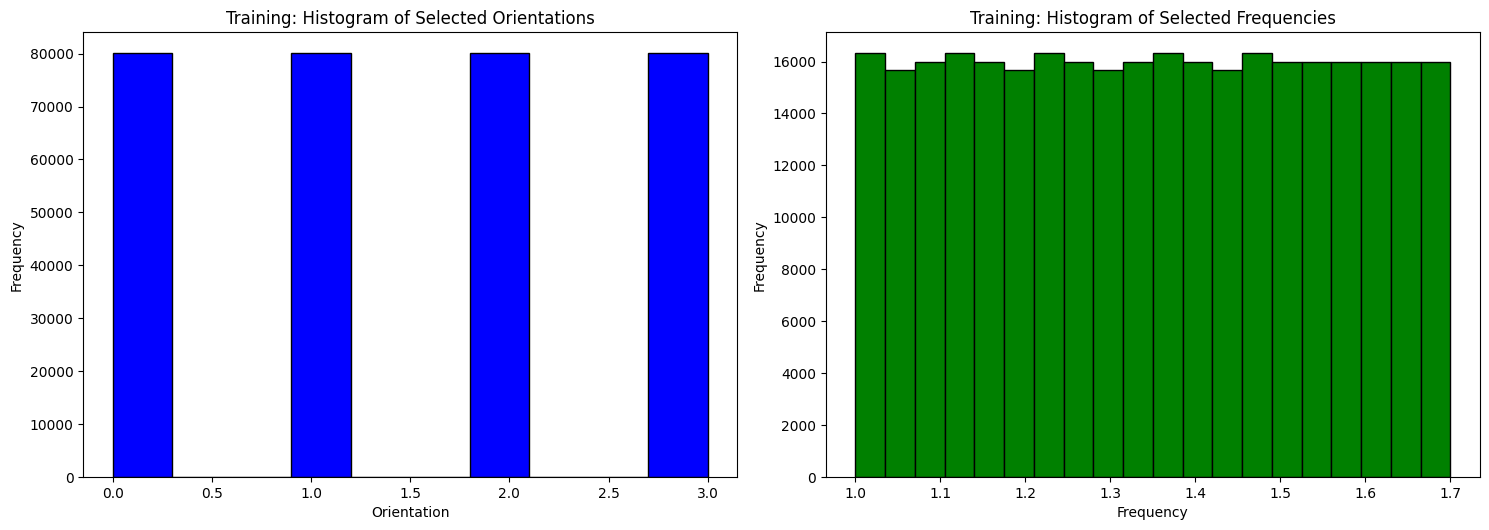

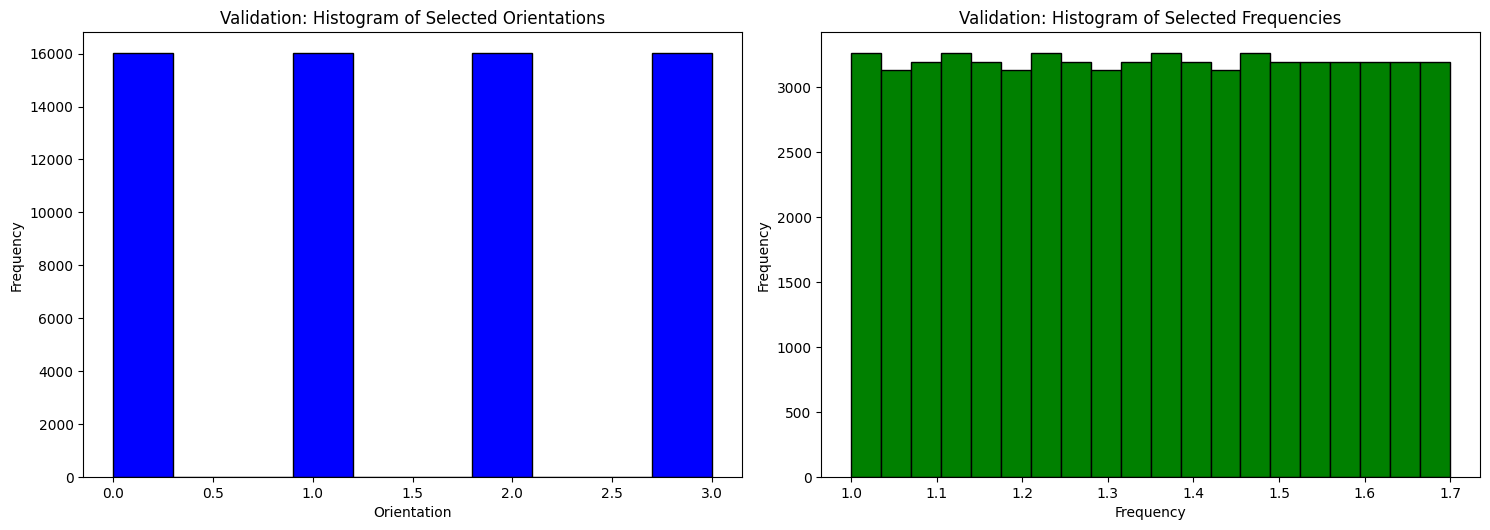

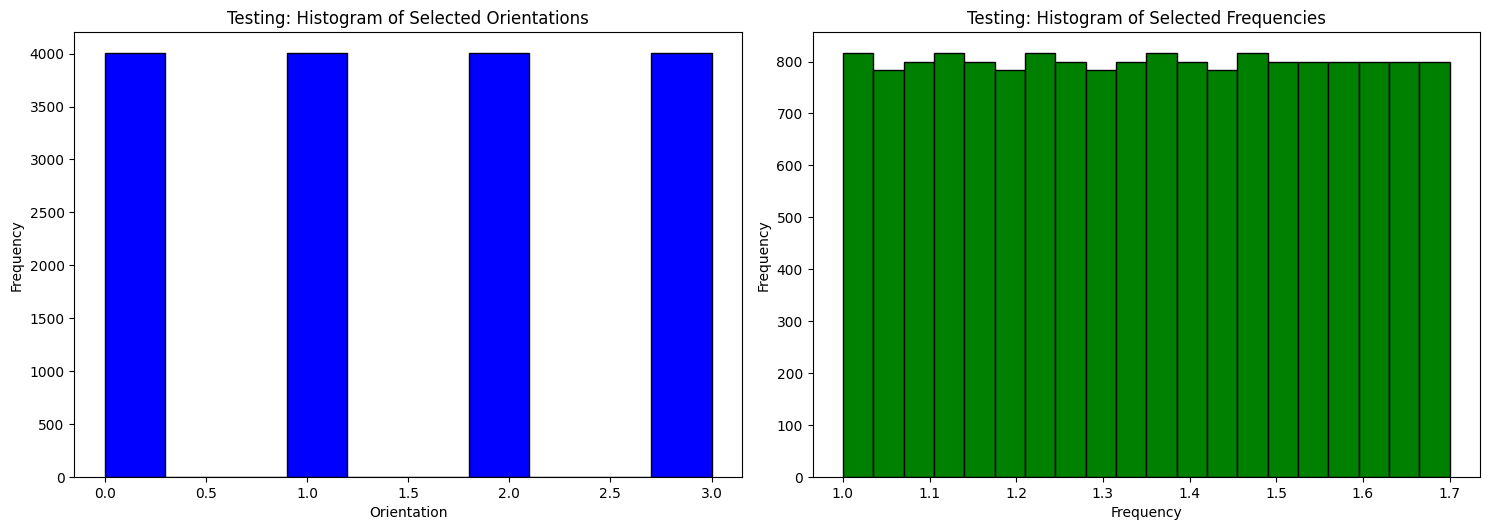

In [462]:
selected_orientations = training_dataframe.loc[X_train_indices, 'Orientation']
selected_frequencies = training_dataframe.loc[X_train_indices, 'Frequency']

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Training: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Training: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

selected_orientations = training_dataframe.loc[X_val_indices, 'Orientation']
selected_frequencies = training_dataframe.loc[X_val_indices, 'Frequency']

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Validation: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Validation: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

selected_orientations = training_dataframe.loc[X_test_indices, 'Orientation']
selected_frequencies = training_dataframe.loc[X_test_indices, 'Frequency']

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Testing: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Testing: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               1152      
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
320/320

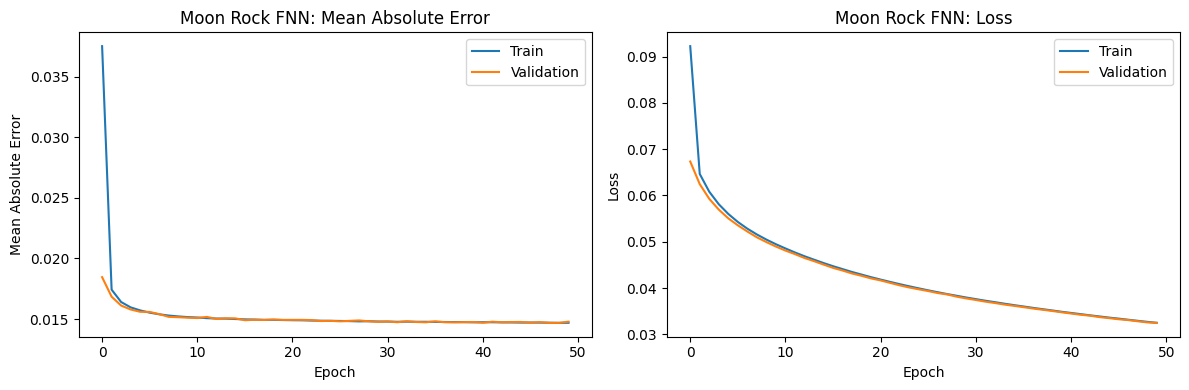

In [463]:
def rmse_loss(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    mean_squared_error = tf.reduce_mean(squared_error)
    root_mean_squared_error = tf.sqrt(mean_squared_error)
    return root_mean_squared_error

ind_no_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])


ind_no_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
              loss=[rmse_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
ind_no_model.summary()
history = ind_no_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1001,shuffle=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Moon Rock FNN: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Moon Rock FNN: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [464]:
xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric=mean_absolute_error,verbosity=3,max_depth=5)
xgb_model.fit(X_train, y_train)

[06:18:17] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[06:18:17] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:18:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=5
[06:18:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=5
[06:18:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=5
[06:18:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=5
[06:18:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=5
[06:18:18] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 32 extra nodes, 0 pruned nodes, max_depth=5
[06:18:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 50 extra nodes, 0 pruned nodes, max_depth=5
[06:18:19] INFO: ../src/tree/updater_prune.cc:98: tree pruning end,

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7de5cce471c0>,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=250, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [465]:
batch_size = 1001
y_pred_no = ind_no_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_no = y_pred_no.reshape(-1, batch_size, y_pred_no.shape[-1])
y_pred_xgb = y_pred_xgb.reshape(-1, batch_size, y_pred_xgb.shape[-1])
y_test = y_test.reshape(-1, batch_size, y_test.shape[-1])
y_pred_no = np.mean(y_pred_no, axis=1)
y_pred_xgb = np.mean(y_pred_xgb, axis=1)
y_test = np.mean(y_test, axis=1)
y_pred_0_no, y_test_0 = y_pred_no[:, 0], y_test[:, 0]
y_pred_1_no, y_test_1 = y_pred_no[:, 1], y_test[:, 1]
y_pred_0_xgb, _ = y_pred_xgb[:, 0], _
y_pred_1_xgb, _ = y_pred_xgb[:, 1], _
y_pred_0_no = np.clip(y_pred_0_no, 0.0, 0.2)
y_pred_1_no = np.clip(y_pred_1_no, 0.0, 0.2)
y_pred_0_xgb = np.clip(y_pred_0_xgb, 0.0, 0.2)
y_pred_1_xgb = np.clip(y_pred_1_xgb, 0.0, 0.2)

501/501 [==============================] - 3s 6ms/step


In [466]:
mse_xgb = mean_squared_error(y_test_0, y_pred_0_xgb)
mae_xgb = mean_absolute_error(y_test_0, y_pred_0_xgb)
r_squared_xgb = r2_score(y_test_0, y_pred_0_xgb)
mse_no = mean_squared_error(y_test_0, y_pred_0_no)
mae_no = mean_absolute_error(y_test_0, y_pred_0_no)
r_squared_no = r2_score(y_test_0, y_pred_0_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.0000
MAE: 0.0002
R-squared (R²): 0.8977

Metrics for FNN Model:
MSE: 0.0000
MAE: 0.0004
R-squared (R²): 0.5036


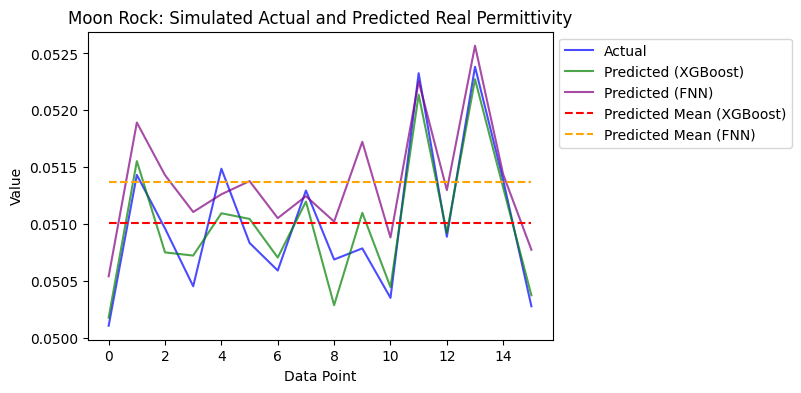

In [467]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_0)), y_test_0, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_xgb), np.mean(y_pred_0_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_no), np.mean(y_pred_0_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Moon Rock: Simulated Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [468]:
mse_xgb = mean_squared_error(y_test_1, y_pred_1_xgb)
mae_xgb = mean_absolute_error(y_test_1, y_pred_1_xgb)
r_squared_xgb = r2_score(y_test_1, y_pred_1_xgb)
mse_no = mean_squared_error(y_test_1, y_pred_1_no)
mae_no = mean_absolute_error(y_test_1, y_pred_1_no)
r_squared_no = r2_score(y_test_1, y_pred_1_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.0000
MAE: 0.0007
R-squared (R²): -0.0154

Metrics for FNN Model:
MSE: 0.0000
MAE: 0.0022
R-squared (R²): -7.4202


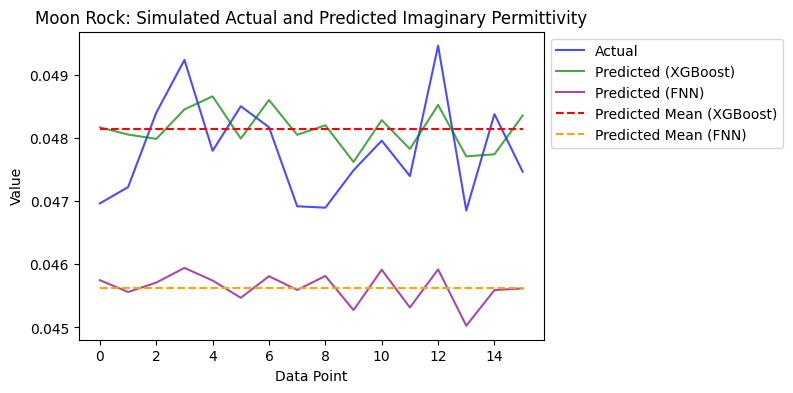

In [469]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_1)), y_test_1, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_xgb), np.mean(y_pred_1_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_no), np.mean(y_pred_1_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Moon Rock: Simulated Actual and Predicted Imaginary Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [470]:
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
X_test = X_test.astype(float)
y_test = y_test.astype(float)
batch_size = 1001
y_pred_no = ind_no_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_no = y_pred_no.reshape(-1, batch_size, y_pred_no.shape[-1])
y_pred_xgb = y_pred_xgb.reshape(-1, batch_size, y_pred_xgb.shape[-1])
y_test = y_test.reshape(-1, batch_size, y_test.shape[-1])
y_pred_no = np.mean(y_pred_no, axis=1)
y_pred_xgb = np.mean(y_pred_xgb, axis=1)
y_test = np.mean(y_test, axis=1)
y_pred_0_no, y_test_0 = y_pred_no[:, 0], y_test[:, 0]
y_pred_1_no, y_test_1 = y_pred_no[:, 1], y_test[:, 1]
y_pred_0_xgb, _ = y_pred_xgb[:, 0], _
y_pred_1_xgb, _ = y_pred_xgb[:, 1], _
y_pred_0_no = np.clip(y_pred_0_no, 0.0, 0.2)
y_pred_1_no = np.clip(y_pred_1_no, 0.0, 0.2)
y_pred_0_xgb = np.clip(y_pred_0_xgb, 0.0, 0.2)
y_pred_1_xgb = np.clip(y_pred_1_xgb, 0.0, 0.2)

126/126 [==============================] - 0s 1ms/step


In [471]:
num_obs_test = len(X_test)
data = {'Dataset': [ 'Test'],
        'Number of Observations': [num_obs_test]}
observations_table = pd.DataFrame(data)
print(observations_table)

  Dataset  Number of Observations
0    Test                    4004


In [472]:
mse_xgb = mean_squared_error(y_test_0, y_pred_0_xgb)
mae_xgb = mean_absolute_error(y_test_0, y_pred_0_xgb)
r_squared_xgb = r2_score(y_test_0, y_pred_0_xgb)
mse_no = mean_squared_error(y_test_0, y_pred_0_no)
mae_no = mean_absolute_error(y_test_0, y_pred_0_no)
r_squared_no = r2_score(y_test_0, y_pred_0_no)
print("\nMetrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")


Metrics for FNN Model:
MSE: 0.0000
MAE: 0.0044
R-squared (R²): 0.0000

Metrics for FNN Model:
MSE: 0.0003
MAE: 0.0180
R-squared (R²): 0.0000


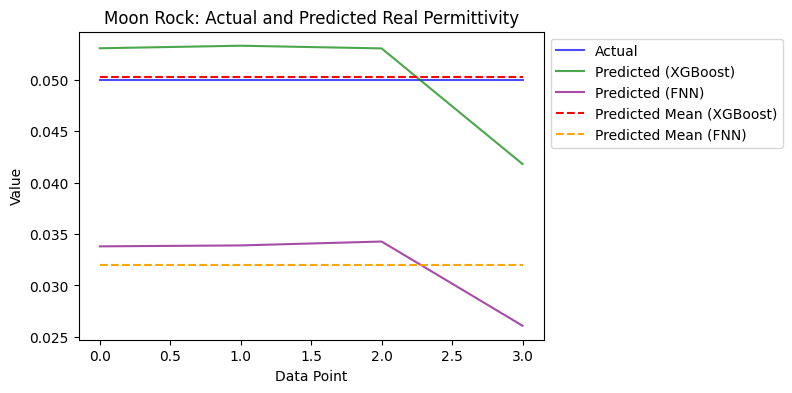

In [473]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_0)), y_test_0, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_xgb), np.mean(y_pred_0_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_no), np.mean(y_pred_0_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Moon Rock: Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [474]:
mse_xgb = mean_squared_error(y_test_1, y_pred_1_xgb)
mae_xgb = mean_absolute_error(y_test_1, y_pred_1_xgb)
r_squared_xgb = r2_score(y_test_1, y_pred_1_xgb)
mse_no = mean_squared_error(y_test_1, y_pred_1_no)
mae_no = mean_absolute_error(y_test_1, y_pred_1_no)
r_squared_no = r2_score(y_test_1, y_pred_1_no)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_no:.4f}")
print(f"MAE: {mae_no:.4f}")
print(f"R-squared (R²): {r_squared_no:.4f}")

Metrics for XGBoost Model:
MSE: 0.0000
MAE: 0.0045
R-squared (R²): 0.0000

Metrics for FNN Model:
MSE: 0.0001
MAE: 0.0080
R-squared (R²): 0.0000


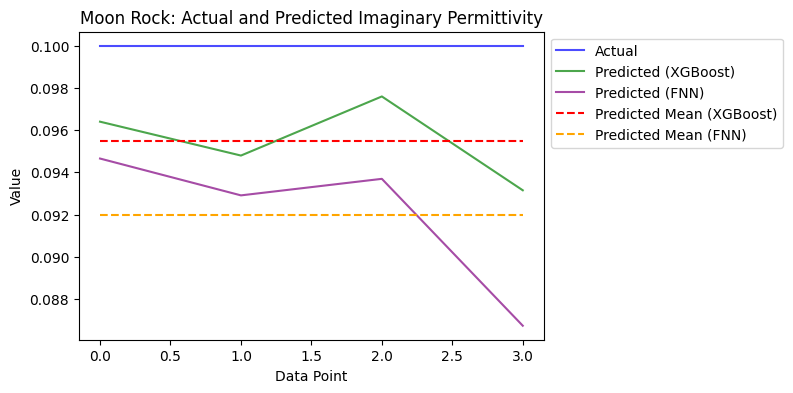

In [475]:
plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_1)), y_test_1, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_no, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_xgb), np.mean(y_pred_1_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_no), np.mean(y_pred_1_no)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.title('Moon Rock: Actual and Predicted Imaginary Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()